# my compiled dataset can be downloaded here:
https://drive.google.com/file/d/1mm30Mvoa3IAYljheIK61F9RhMjxeKggq/view?usp=sharing


In [1]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "<start>"
STOP = "<end>"
EPOCHS = 10
BASE = 'C:/Users/Notna Home/Documents/uni/ml/fresh'
TRAINING_LENGTH = 37000
VALIDATION_LENGTH = 5000

In [2]:
null_punct = str.maketrans('', '', string.punctuation)
lookup_dict = dict()

with open( os.path.join(BASE,'data.txt'), 'r', encoding="UTF-8") as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split("\t")
    if len(line) >= 2: #filter chars and no content lines
      id = tok[1].split(".")[0]
      desc = tok[0].split() #split sentence into words
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      lookup_dict[id] = ' '.join([str(elem) for elem in desc])
      
      #Debug
      #print(id)
      #print(desc)
      
lexicon = set()
for key in lookup_dict:
    lexicon.update(lookup_dict[key].split())

In [3]:

print(len(lookup_dict))  # The reference dictionary
#print(lookup_dict)  # debug
print(len(lexicon)) # How many unique words
#print(lexicon)
print(max_length) # Maximum length of a caption (in words)



42756
14697
42


In [4]:
from random import shuffle
total_images = [os.path.basename(x) for x in glob.glob(os.path.join(BASE,'data/', '*.jpg'))]
print(f'Total images in dataset: {len(total_images)}')

train_images = total_images[:8000]
test_images = total_images[8000:16000]
training_images = {}
validation_images = {}

#print(lookup_dict.items())

Total images in dataset: 42756


In [5]:
train_descriptions = {}
for k in lookup_dict:
  if f'{k}.jpg' in total_images:
    train_descriptions[k] = f'{START} {lookup_dict[k]} {STOP}'
    
print(f'train descriptions length: {len(train_descriptions)}')


train descriptions length: 42756


https://cloud.google.com/tpu/docs/inception-v3-advanced


In [6]:
encoder_model = InceptionV3(weights='imagenet')
encoder_model = Model(encoder_model.input, encoder_model.layers[-2].output)
WIDTH = 299 #inception v3
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

#debug print the summary of the model
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
def image_encode(img):
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x = encoder_model.predict(x) 
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x



Exxtracting features from our training and testing images with our inception v3 encoder model

In [8]:
def load_image_featurs():
    global training_images, validation_images
    training_images = {}
    validation_images = {}
    
    with open(train_path, "rb") as fp:
        encoded_images = pickle.load(fp) #Shuffle
        keys = list(encoded_images.keys())
        shuffle(keys) # Shuffle keys in place to pick random asscosiation from endoded images
        
        for i in range(0,TRAINING_LENGTH):
            training_images[keys[i]]=encoded_images[keys[i]]
        for i in range(TRAINING_LENGTH,TRAINING_LENGTH+VALIDATION_LENGTH):
            validation_images[keys[i]]=encoded_images[keys[i]]
        print(any(k in validation_images.keys() for k,v in training_images.items())) #make sure that no values are in both dicts


        print (f'Loaded features for {len(encoded_images)} elements')
        print (f'Loaded training features for {len(training_images)} elements')
        print (f'Loaded validation features for {len(validation_images)} elements')
    

In [9]:

train_path = os.path.join(BASE,"models/",f'train{OUTPUT_DIM}ALL.pkl')
if not os.path.exists(train_path):
  encoded_images = {}
  for id in tqdm(train_images):
    image_path = os.path.join(BASE,'data', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    
    encoded_images[id] = image_encode(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoded_images, fp)
  load_image_featurs()
else:
  load_image_featurs()

False
Loaded features for 42756 elements
Loaded training features for 37000 elements
Loaded validation features for 5000 elements


We are stripping words that are less common because it produces bad resulsts to train with rare words

In [10]:

word_count_threshold = 3
word_counts = {}
nsents = 0
for sent in train_descriptions.values():
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 14699 ==> 8242


Build lookup tables for later

In [11]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 

max_length +=2
print(wordtoidx["<start>"])
print(idxtoword[1])
print(max_length)
print(vocab_size)
#print(idxtoword)



1
<start>
44
8243


Get glove 6b200d from this url: https://www.kaggle.com/incorpes/glove6b200d/version/1


In [12]:
embeddings_index = {} 
f = open(os.path.join(BASE, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')



400000it [00:14, 27117.94it/s]

Found 400000 word vectors.


In [13]:


embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))



for word, i in wordtoidx.items():
    #print(word)
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        #print(embedding_vector)
        #print("added word: " + word)

#print(embeddings_index.get("awesome"))



(?, 200)
is the shape we expect from the glove embeddings index

In [14]:
print(embedding_matrix.shape)

(8243, 200)


In [15]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2) # softmax output layer that we will use argmax on to get word
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [16]:


caption_model.summary()
from keras.utils.vis_utils import plot_model
plot_model(caption_model, to_file=os.path.join(BASE,'model_plot.png'), show_shapes=True, show_layer_names=True)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 44, 200)      1648600     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

Now we need to make sure that we dont train the glover layer but use it as a filter in the model

In [17]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
opt = optimizers.Adam(learning_rate=10e-6)
caption_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #Get metrics
print(caption_model.summary())



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 44, 200)      1648600     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [18]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    #print(photos)
    for key, encoded_photo in photos.items():
      desc = descriptions[key.split(".jpg")[0]]
      n+=1
      photo = encoded_photo
      seq = []

      for  word in desc.split(' '):
        if word in wordtoidx:
          seq.append(wordtoidx[word])
      # Generate a training case for every possible sequence and outcome
      for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        #print(max_length)
        #print(idxtoword[in_seq])
        x1.append(photo)
        x2.append(in_seq)
        y.append(out_seq)
      if n==num_photos_per_batch: #Yield data after we reach batch size
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

Debug generator output

In [19]:
pics_per_batch = 64 # Determine if a much higher batch performs better
print(pics_per_batch)
#print(next(data_generator(train_descriptions, training_images, 
#                    wordtoidx, max_length, pics_per_batch)))# debug


64


In [20]:
from keras import callbacks
callbacks_list = [callbacks.ModelCheckpoint(
    filepath=os.path.join(BASE,'trained_model/model.hdf5'),
    monitor='val_loss',
    save_best_only=True,
),callbacks.EarlyStopping(
    monitor ="val_loss", 
    mode ="min", patience = 3, 
    restore_best_weights = True)]


In [21]:

samples_per_epoch = 0
for k in train_descriptions:
    if k+".jpg" in training_images:
        samples_per_epoch+=len(train_descriptions[k].split())-1
print(samples_per_epoch)

377319


In [22]:
def display_stats():
    plt.plot(caption_model.history.history['accuracy'])
    plt.plot(caption_model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    
    plt.plot(caption_model.history.history['loss'])
    plt.plot(caption_model.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Dataset total size:42756
Dataset used size:42000
pictures per batch:64
steps for training:578
steps for validation:578
Epoch 1/20
578/578 [==============================] - 127s 215ms/step - loss: 7.5732 - accuracy: 0.0883 - val_loss: 6.5585 - val_accuracy: 0.1081
Epoch 2/20


C:\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


578/578 [==============================] - 123s 212ms/step - loss: 6.5227 - accuracy: 0.1220 - val_loss: 6.4787 - val_accuracy: 0.1299
Epoch 3/20
578/578 [==============================] - 121s 210ms/step - loss: 6.4635 - accuracy: 0.1291 - val_loss: 6.4360 - val_accuracy: 0.1318
Epoch 4/20
578/578 [==============================] - 125s 217ms/step - loss: 6.4232 - accuracy: 0.1312 - val_loss: 6.3984 - val_accuracy: 0.1352
Epoch 5/20
578/578 [==============================] - 120s 208ms/step - loss: 6.3885 - accuracy: 0.1331 - val_loss: 6.3640 - val_accuracy: 0.1372
Epoch 6/20
578/578 [==============================] - 119s 205ms/step - loss: 6.3527 - accuracy: 0.1353 - val_loss: 6.3280 - val_accuracy: 0.1391
Epoch 7/20
578/578 [==============================] - 118s 204ms/step - loss: 6.3159 - accuracy: 0.1384 - val_loss: 6.2891 - val_accuracy: 0.1430
Epoch 8/20
578/578 [==============================] - 117s 203ms/step - loss: 6.2787 - accuracy: 0.1422 - val_loss: 6.2509 - val_accura

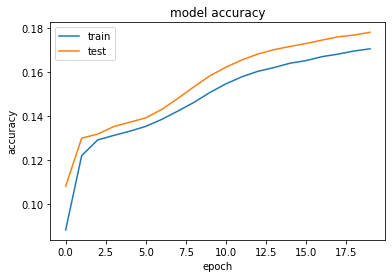

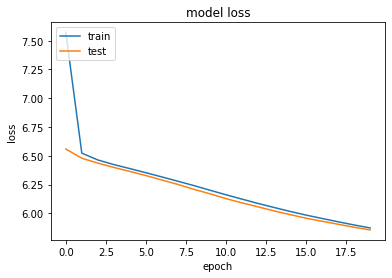

Epoch 1/10
289/289 [==============================] - 56s 193ms/step - loss: 5.8260 - accuracy: 0.1728 - val_loss: 5.7554 - val_accuracy: 0.1824
Epoch 2/10
289/289 [==============================] - 55s 191ms/step - loss: 5.7153 - accuracy: 0.1774 - val_loss: 5.6577 - val_accuracy: 0.1861
Epoch 3/10
289/289 [==============================] - 55s 192ms/step - loss: 5.6131 - accuracy: 0.1808 - val_loss: 5.5722 - val_accuracy: 0.1899
Epoch 4/10
289/289 [==============================] - 56s 192ms/step - loss: 5.5233 - accuracy: 0.1840 - val_loss: 5.5014 - val_accuracy: 0.1929
Epoch 5/10
289/289 [==============================] - 56s 195ms/step - loss: 5.4440 - accuracy: 0.1867 - val_loss: 5.4393 - val_accuracy: 0.1966
Epoch 6/10
289/289 [==============================] - 56s 193ms/step - loss: 5.3742 - accuracy: 0.1891 - val_loss: 5.3845 - val_accuracy: 0.1995
Epoch 7/10
289/289 [==============================] - 55s 190ms/step - loss: 5.3109 - accuracy: 0.1910 - val_loss: 5.3373 - val_ac

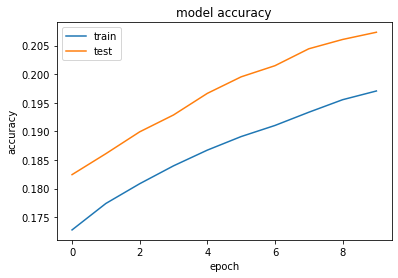

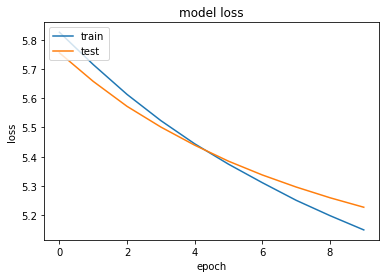

In [23]:



steps = (TRAINING_LENGTH//pics_per_batch)
steps_val = (TRAINING_LENGTH//pics_per_batch)

print(f"Dataset total size:{len(train_descriptions)}")
print(f"Dataset used size:{TRAINING_LENGTH+VALIDATION_LENGTH}")
print(f"pictures per batch:{pics_per_batch}")

print(f"steps for training:{steps}")
print(f"steps for validation:{steps_val}")
#print(wordtoidx)
model_path = os.path.join(BASE,'trained_model/model.hdf5')
if not os.path.exists(model_path) or True: #or true can be used for debugging and always training a model
  
  ####### Generators
  generator = data_generator(train_descriptions, training_images, 
                wordtoidx, max_length, pics_per_batch) #testing encodings
  generator_val = data_generator(train_descriptions, validation_images, 
                wordtoidx, max_length, pics_per_batch) #testing encodings
  
  #fit the model
  caption_model.fit(generator, epochs=EPOCHS*5,
                steps_per_epoch=steps, verbose=1, validation_data=generator_val,
                validation_steps=steps_val, 
                callbacks=callbacks_list)
  
  display_stats()
  caption_model.optimizer.lr = 1e-4 # Document this logic
  pics_per_batch = pics_per_batch*2 # Document this logic 
  
  #reasign steps
  steps = (len(training_images)//pics_per_batch)
  steps_val = (len(validation_images)//pics_per_batch)

####### Generators
  generator = data_generator(train_descriptions, training_images, 
                wordtoidx, max_length, pics_per_batch)
  generator_val = data_generator(train_descriptions, validation_images, 
              wordtoidx, max_length, pics_per_batch) #testing encodings
  #fit the model
  caption_model.fit(generator, epochs=EPOCHS*3,
                steps_per_epoch=steps, verbose=1, validation_data=generator_val,
                validation_steps=steps_val, 
                callbacks=callbacks_list)
  display_stats()
  caption_model.save_weights(model_path + ".last") # save last epoch just in case
else:
  caption_model.load_weights(model_path)
    

In [24]:


def generate_caption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final
# https://github.com/yashk2810/Image-Captioning/blob/master/Image%20Captioning%20InceptionV3.ipynb
def generate_caption_beam_search(image, beam_index=3):
    start = [wordtoidx["<start>"]]
    
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            #e = validation_images[image]
            preds = caption_model.predict([np.array(image), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    start_word = start_word[-1][0]
    intermediate_caption = [idxtoword[i] for i in start_word]
    
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption
        


images generated with the validation test set:


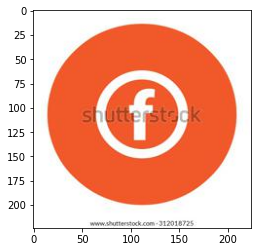

Caption regular generation: vector illustration of the flag
Caption beam search[3]: vector illustration of flag in the form
Caption beam search[4]: vector illustration of flag on white background
Caption beam search[5]: vector illustration of flag on white background


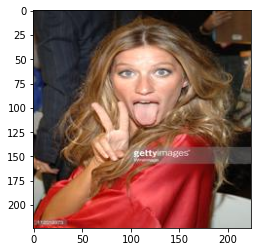

Caption regular generation: actor in the premiere
Caption beam search[3]: portrait of young woman in the premiere
Caption beam search[4]: portrait of young woman in the premiere
Caption beam search[5]: portrait of young woman in the premiere


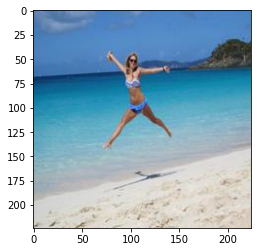

Caption regular generation: the beach on the beach
Caption beam search[3]: the beach on the beach
Caption beam search[4]: the beach on the beach
Caption beam search[5]: the beach in the beach


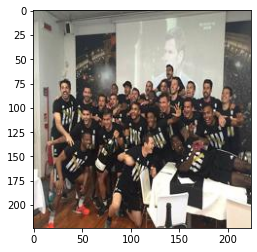

Caption regular generation: person in the team
Caption beam search[3]: person in the premiere
Caption beam search[4]: person in the event
Caption beam search[5]: person in the event


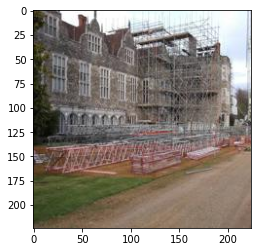

Caption regular generation: the city of the town
Caption beam search[3]: view view of the city
Caption beam search[4]: view view of the city
Caption beam search[5]: the view of the town


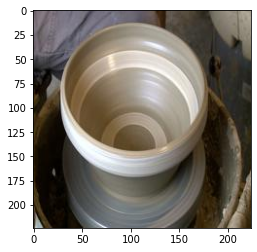

Caption regular generation: the of the world
Caption beam search[3]: biological species on white background
Caption beam search[4]: close up of the water
Caption beam search[5]: close up of biological species on white background


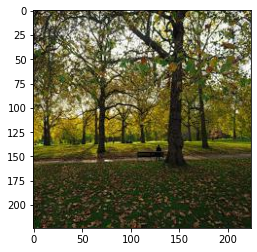

Caption regular generation: the tree in the garden
Caption beam search[3]: trees tree in the garden
Caption beam search[4]: trees tree in the garden
Caption beam search[5]: trees tree in the garden


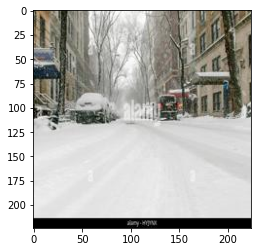

Caption regular generation: the snow in the snow
Caption beam search[3]: the snow in the snow
Caption beam search[4]: the snow in the snow
Caption beam search[5]: the snow in the snow


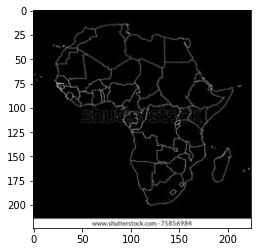

Caption regular generation: vector illustration of the background
Caption beam search[3]: vector illustration of the shape
Caption beam search[4]: vector illustration of the map
Caption beam search[5]: vector illustration of the shape


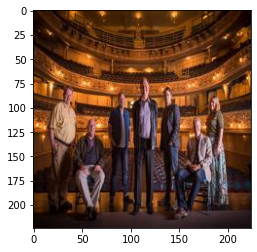

Caption regular generation: the crowd of the crowd
Caption beam search[3]: person in the event
Caption beam search[4]: person in the event
Caption beam search[5]: person in the event


In [25]:
import random
print("images generated with the validation test set:")
for z in range(10):
  z+=120 #get random place in dataset
  pic = list(validation_images.keys())[random.randint(0, len(validation_images))]
  image = validation_images[pic].reshape((1,OUTPUT_DIM))
  #print(os.path.join(BASE,'data', pic))
  x=plt.imread(os.path.join(BASE,'data', pic))
  plt.imshow(x)
  plt.show()
  print("Caption regular generation:",generate_caption(image))
  print("Caption beam search[3]:",generate_caption_beam_search(image, beam_index=3))
  print("Caption beam search[4]:",generate_caption_beam_search(image, beam_index=4))
  print("Caption beam search[5]:",generate_caption_beam_search(image, beam_index=5))
  
  

images generated with unseen test set:


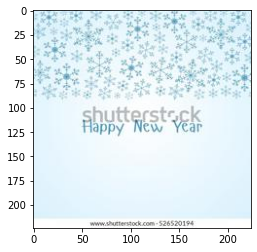

(1, 2048)
Caption regular generation: vector illustration of the map
Caption beam search[3]: vector illustration of the map
Caption beam search[4]: vector illustration of the map
Caption beam search[5]: vector illustration of the map


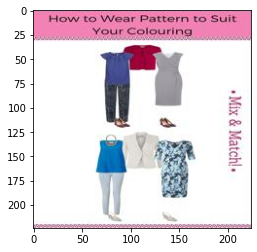

(1, 2048)
Caption regular generation: vector illustration of the style
Caption beam search[3]: vector illustration of the flag
Caption beam search[4]: vector illustration of the flag
Caption beam search[5]: vector illustration of the background


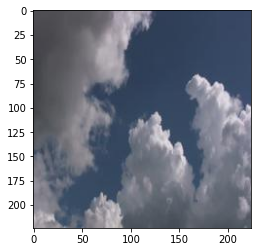

(1, 2048)
Caption regular generation: the clouds of the sky
Caption beam search[3]: clouds clouds over the wind
Caption beam search[4]: aerial view of the wind
Caption beam search[5]: aerial view of the wind


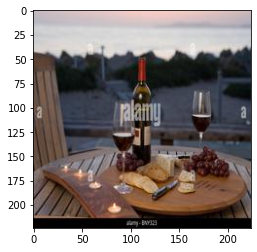

(1, 2048)
Caption regular generation: the kitchen room in the table
Caption beam search[3]: the kitchen room in the table
Caption beam search[4]: view of the dining room
Caption beam search[5]: view of the dining room


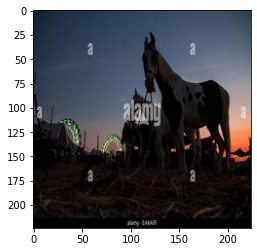

(1, 2048)
Caption regular generation: the horse in the horse
Caption beam search[3]: horse in the road
Caption beam search[4]: horse in the road
Caption beam search[5]: horse in the forest


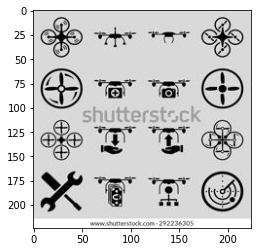

(1, 2048)
Caption regular generation: vector illustration of the style
Caption beam search[3]: vector illustration of the map
Caption beam search[4]: vector illustration of the map
Caption beam search[5]: vector illustration of the world


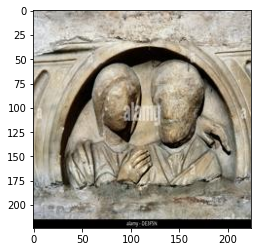

(1, 2048)
Caption regular generation: the old is in the world
Caption beam search[3]: painting of the world
Caption beam search[4]: painting of the world
Caption beam search[5]: painting of the world


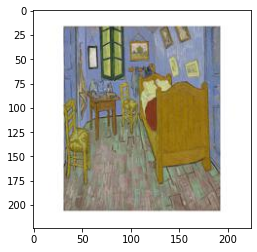

(1, 2048)
Caption regular generation: illustration of the house
Caption beam search[3]: vector illustration of the house
Caption beam search[4]: vector illustration of the house
Caption beam search[5]: vector illustration of the house


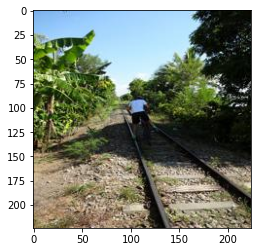

(1, 2048)
Caption regular generation: the road in the road
Caption beam search[3]: view view of the road
Caption beam search[4]: train on the road
Caption beam search[5]: train in the road


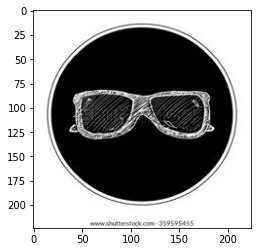

(1, 2048)
Caption regular generation: vector illustration of the background
Caption beam search[3]: vector illustration of the heart
Caption beam search[4]: vector illustration of the background
Caption beam search[5]: vector illustration of the background


In [26]:
print("images generated with unseen test set:")
testing_dir = os.path.join(BASE, "testing_set/")
files = os.listdir(testing_dir)
for z in range(10):
    
    img = Image.open(testing_dir+files[random.randint(0, len(files))])
    img.load()

    plt.imshow(img)
    plt.show()

    img = image_encode(img).reshape((1,OUTPUT_DIM))
    print(img.shape)
    print("Caption regular generation:",generate_caption(img))
    print("Caption beam search[3]:",generate_caption_beam_search(img, beam_index=3))
    print("Caption beam search[4]:",generate_caption_beam_search(img, beam_index=4))
    print("Caption beam search[5]:",generate_caption_beam_search(img, beam_index=5))

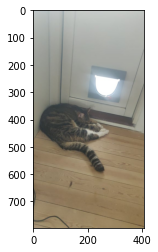

(1, 2048)
Caption regular generation: cat cat in the window
Caption beam search[3]: cat in the water
Caption beam search[4]: biological species in the water
Caption beam search[5]: biological species in the water


In [27]:
img = Image.open(os.path.join(BASE,"andy.jpg"))
img.load()
#img = img.rotate(20)

plt.imshow(img)
plt.show()

img = image_encode(img).reshape((1,OUTPUT_DIM))
print(img.shape)
print("Caption regular generation:",generate_caption(img))
print("Caption beam search[3]:",generate_caption_beam_search(img, beam_index=3))
print("Caption beam search[4]:",generate_caption_beam_search(img, beam_index=4))
print("Caption beam search[5]:",generate_caption_beam_search(img, beam_index=5))